In [1]:
import torch
import numpy as np
import os
import h5py
import scipy
from scipy.io import savemat
import numpy as np
import pandas as pd
from scipy import io
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from collections import Counter
import networkx as nx
from scipy.stats import shapiro
from statannotations.Annotator import Annotator
import statistics
import matplotlib.ticker as mtick
from matplotlib.pyplot import MultipleLocator


In [26]:
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    # data = np.arange(1,1008)
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = np.zeros(int(allregions*(allregions-1)*0.5))
            for sub in data[test_index]:
                sub_edge = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_edge_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                sub_edge = (sub_edge+np.transpose(sub_edge))*0.5
                sub_edge = sub_edge[np.tril_indices_from(sub_edge,-1)]
                sub_edge = (sub_edge-sub_edge.min())/(sub_edge.max()-sub_edge.min())
                one_task_all_sub = sub_edge + one_task_all_sub
            all_task_all_sub.append((one_task_all_sub-one_task_all_sub.min())/(one_task_all_sub.max()-one_task_all_sub.min()))
        five_fold.append(all_task_all_sub)
    all_lobe.append(five_fold)
# average_value_conn = np.array(all_lobe).transpose(2,3,0,1).reshape(7,219*109,-1)

In [277]:
# 可视化四种图论指标 每个脑区的值
all_average = np.sum(conn_value,1)
four_vlaue = []
for task in range(7):
    topk = np.argsort(-all_average[task])[0:int(0.05*11935)]
    ax_all = []
    for conn in topk:
        x_axix = np.tril_indices_from(np.zeros((155,155)),-1)[0][conn]
        y_axix = np.tril_indices_from(np.zeros((155,155)),-1)[1][conn]
        ax_all.append([x_axix,y_axix])
    G = nx.Graph()
    G.add_nodes_from(range(155))
    G.add_edges_from(ax_all)
    all_0 = [i[1] for i  in nx.degree(G)]
    all_1 = list(nx.clustering(G).values())
    all_2 = list(nx.betweenness_centrality(G).values())
    all_3 = dict(nx.shortest_path_length(G))
    all_4 = []
    for node in range(155):
        value_signal_node = sum(all_3[node].values())
        all_4.append(value_signal_node/155)
    four_vlaue.append((all_0,all_1,all_2,all_4))

In [27]:
s,g,sub = [],[],[]
conn_value = np.array(all_lobe).reshape(30,7,-1).transpose(1,0,2)
for task in range(7):
    for model_num in range(30):
        for percent in np.arange(0.005,0.2,0.01):
            topk = np.argsort(-conn_value[task][model_num])[0:int(percent*allregions*(allregions-1)*0.5)]
            ax_all = []
            for conn in topk:
                x_axix = np.tril_indices_from(np.zeros((allregions,allregions)),-1)[0][conn]
                y_axix = np.tril_indices_from(np.zeros((allregions,allregions)),-1)[1][conn]
                ax_all.append([x_axix,y_axix])
            G = nx.Graph()
            G.add_nodes_from(np.unique(ax_all))
            G.add_edges_from(ax_all)
            
            betweenness_centrality = list(nx.betweenness_centrality(G).items())
            bet_all_s = [i[1] for i  in betweenness_centrality if i[0]%2 == 0 and i[0]<cortical_regions]
            bet_all_g = [i[1] for i  in betweenness_centrality if i[0]%2 == 1 and i[0]<cortical_regions]
            bet_all_sub = [i[1] for i  in betweenness_centrality if  i[0]>cortical_regions-1]
            
            clustering = list(nx.clustering(G).items())
            clus_all_s = [i[1] for i  in clustering if i[0]%2 == 0 and i[0]<cortical_regions]
            clus_all_g = [i[1] for i  in clustering if i[0]%2 == 1 and i[0]<cortical_regions]
            clus_all_sub = [i[1] for i  in clustering if  i[0]>cortical_regions-1]

            degree = list(nx.degree(G))
            degree_all_s = [i[1] for i  in degree if i[0]%2 == 0 and i[0]<cortical_regions]
            degree_all_g = [i[1] for i  in degree if i[0]%2 == 1 and i[0]<cortical_regions]
            degree_all_sub = [i[1] for i  in degree if  i[0]>cortical_regions-1]

            all_3 = dict(nx.shortest_path_length(G))
            shortest_path_length = []
            for node in np.unique(ax_all):
                value_signal_node = sum(all_3[node].values())
                shortest_path_length.append((node,value_signal_node/len(np.unique(ax_all))))
            st_all_s = [i[1] for i  in shortest_path_length if i[0]%2 == 0 and i[0]<cortical_regions]
            st_all_g = [i[1] for i  in shortest_path_length if i[0]%2 == 1 and i[0]<cortical_regions]
            st_all_sub = [i[1] for i  in shortest_path_length if  i[0]>cortical_regions-1]

            # all_0 = dict(nx.shortest_path_length(G))
            # all_st = []
            # for node in range(155):
            #     value_signal_node = sum(all_0[node].values())
            #     all_st.append(value_signal_node/155)
            s.append((np.mean(bet_all_s),np.mean(bet_all_g),np.mean(bet_all_sub),
                      np.mean(clus_all_s),np.mean(clus_all_g),np.mean(clus_all_sub),
                      np.mean(degree_all_s),np.mean(degree_all_g),np.mean(degree_all_sub),
                      np.mean(st_all_s),np.mean(st_all_g),np.mean(st_all_sub)))
            # all_0_g = np.mean(all_0[1:136:2])
            # all_0_sub = np.mean(all_0[136:155])


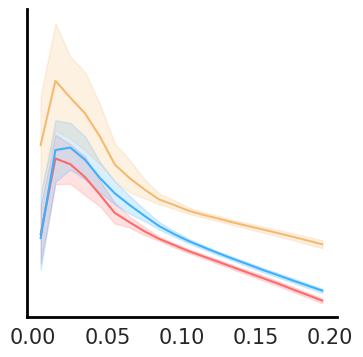

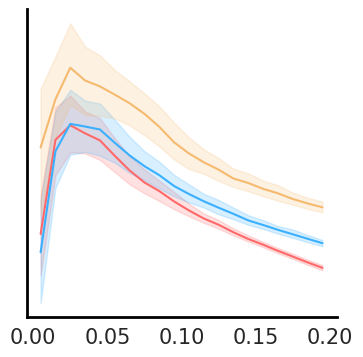

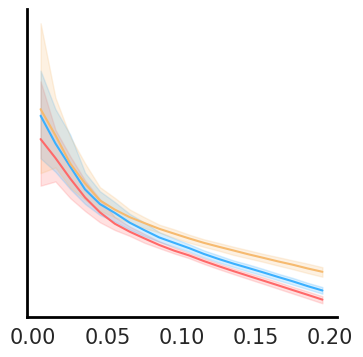

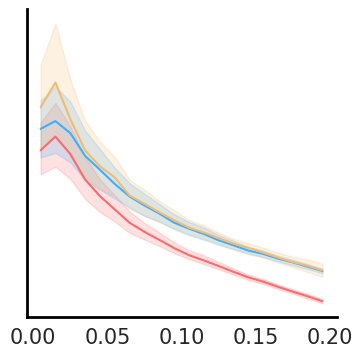

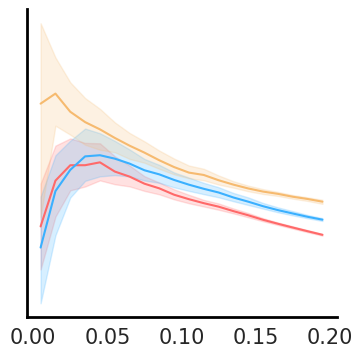

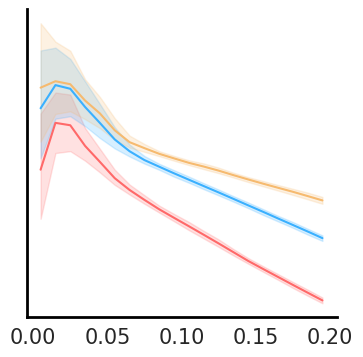

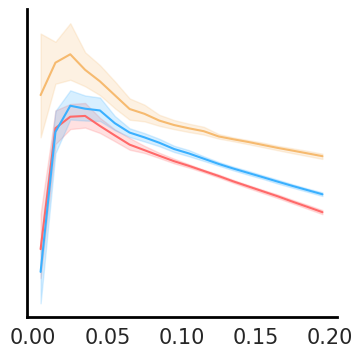

In [28]:
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
flatui = ["#FF6969", "#3AB0FF","#F6BA6F"]
for task_now in range(7):
    column = ['value']
    df = pd.DataFrame(columns=column,data = np.transpose(s)[9:12].transpose()[600*task_now:600*(task_now+1)].reshape(-1))
    df.insert(loc=1, column='conn_type', value=list(range(0,3))*600)
    df.insert(loc=2, column='tholhold', value=list(np.repeat(np.arange(0.005,0.2,0.01),3))*30)
    sns.set_style("whitegrid", {'axes.grid' : False})
    six_regions_name = ['sulci','gyri','sub']
    fig,ax = plt.subplots(figsize=(4,4))                
    graph_value = df
    for i in np.arange(0,len(graph_value['conn_type'])):
        graph_value['conn_type'][i] = six_regions_name[graph_value['conn_type'][i]%3]    
    ax = sns.lineplot( x=graph_value["tholhold"],y=graph_value["value"],hue=graph_value['conn_type'],palette = sns.color_palette(flatui))
    ax.get_legend().remove()
    plt.ylabel('',fontsize=40)
    plt.xlabel('',fontsize=30,weight='bold')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    y_major_locator=MultipleLocator(5)
    ax = plt.gca()
    ax.yaxis.set_major_locator(y_major_locator)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    # plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/aparc/graph/degree_{}.svg".format(CLS2IDX[task_now]), bbox_inches = 'tight',dpi=300,format="svg")


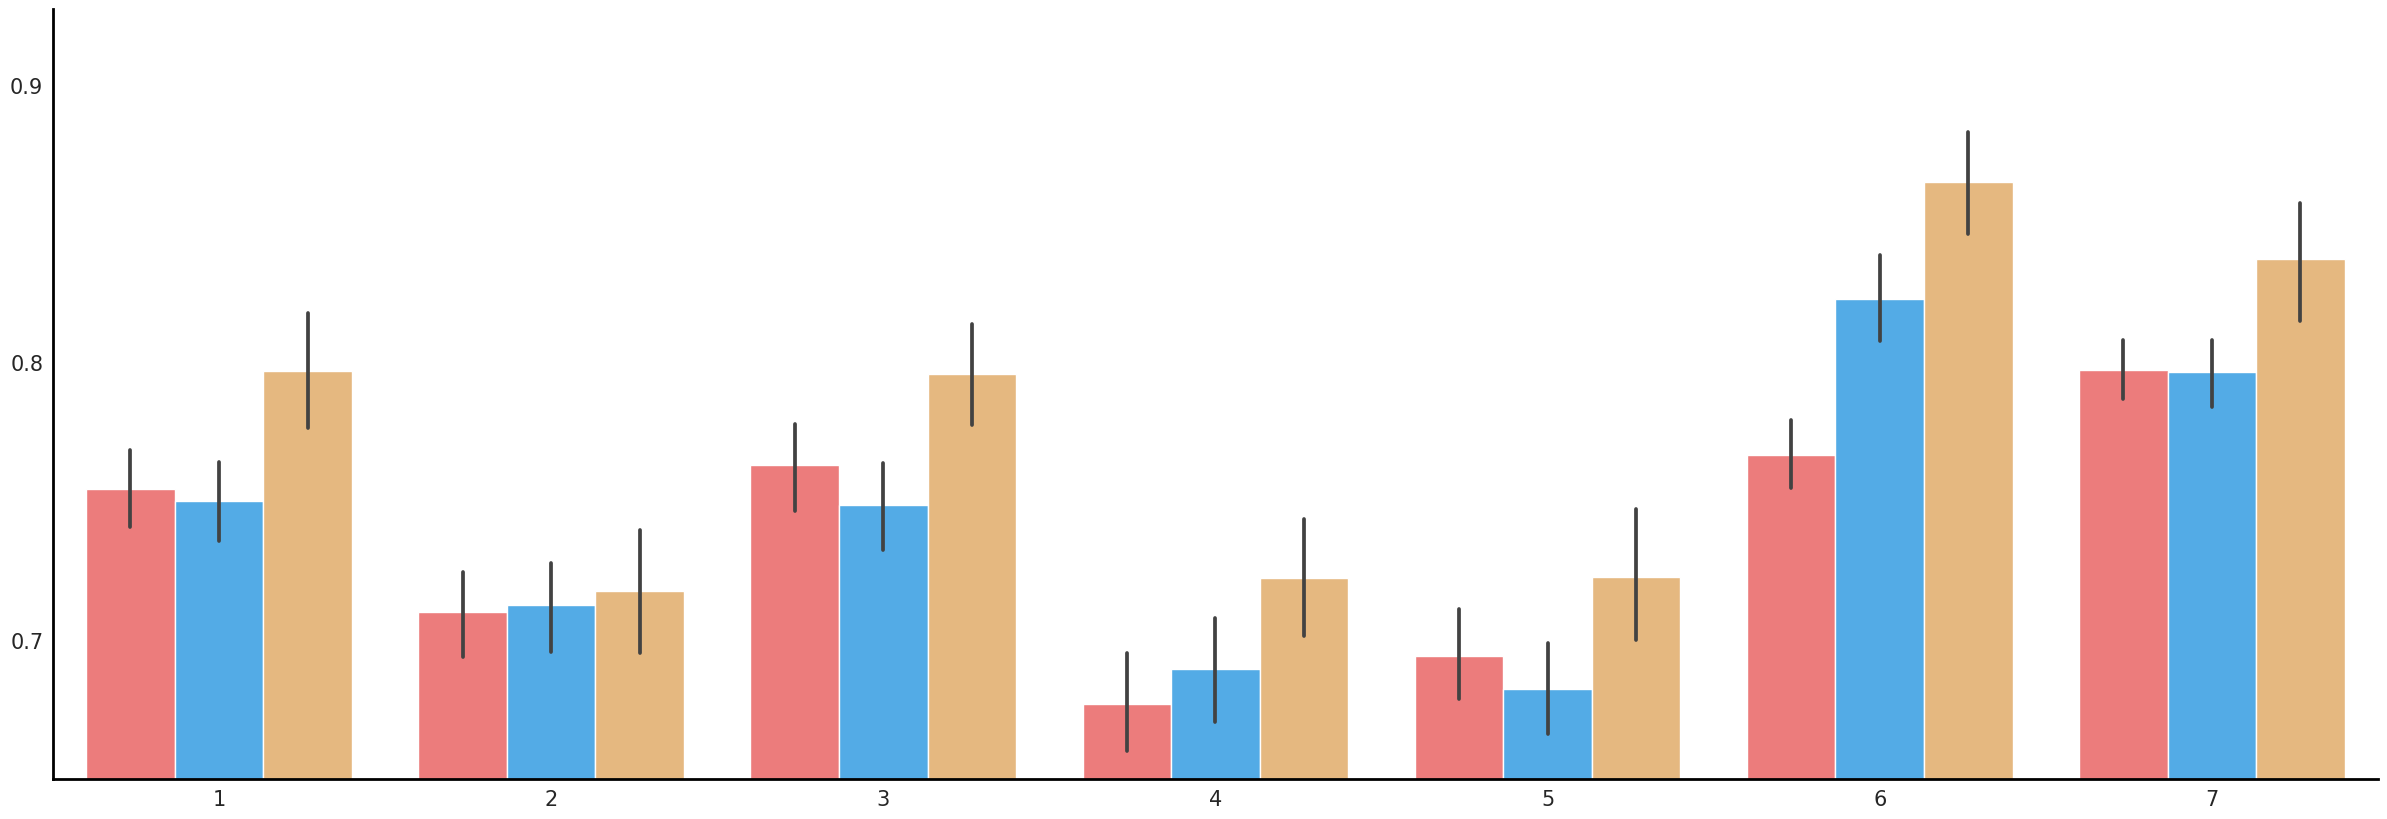

In [33]:
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
flatui = ["#FF6969", "#3AB0FF","#F6BA6F"]
column = ['value']
df = pd.DataFrame(columns=column,data = np.transpose(s)[3:6].transpose().reshape(-1))

df.insert(loc=1, column='conn_type', value=list(range(0,3))*600*7)
df.insert(loc=2, column='tholhold', value=list(np.repeat(np.arange(0.005,0.2,0.01),3))*30*7)
df.insert(loc=3, column='task_type', value=np.repeat(np.arange(1,8),1800))
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['sulci','gyri','sub']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['conn_type'])):
    graph_value['conn_type'][i] = six_regions_name[graph_value['conn_type'][i]%3]    
ax = sns.barplot( x=graph_value["task_type"],y=graph_value["value"],hue=graph_value['conn_type'],palette = sns.color_palette(flatui))
ax.get_legend().remove()
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
y_major_locator=MultipleLocator(0.1)

ax.set_ylim(bottom=0.65)

ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/aparc/graph/degree_{}.svg".format(CLS2IDX[task_now]), bbox_inches = 'tight',dpi=300,format="svg")
